# 04. Alpha Diversity 

Author: Willem Fuetterer


In this Jupyter Notebook the alpha diversity of the samples is analyzed.

**Exercise overview:**<br>
[1. Setup](#setup)<br>
[2. Identification of correct sampling depth](#depth)<br>
[3. Calculating the core metrics for alpha and beta diversity](#calc)<br>
[4. Testing the associations between categorical metadata columns and the diversity metric](#categorical)<br>
[5. Testing whether numeric sample metadata columns are correlated with microbial community richness](#numeric)<br>
[6. Plotting figures](#figures)<br>

<a id='setup'></a>

## 1. Setup

In [2]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import biom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from scipy.stats import spearmanr
from scipy.stats import linregress

%matplotlib inline

In [3]:
# defining location of data
raw_data_dir = "../data/raw"
data_dir = "../data/processed"
vis_dir  = "../results"

<a id='depth'></a>

## 2. Identification of correct sampling depth

In [4]:
! qiime tools peek $data_dir/table-filtered.qza #-> FeatureTable[Frequency]

UUID:        702565bb-ce3d-472e-acd6-4b914601f892
Type:        FeatureTable[Frequency]
Data format: BIOMV210DirFmt


In [12]:
! qiime tools peek $data_dir/taxonomy.qza #-> FeatureData[Taxonomy]

UUID:        0eabf2a9-d83b-4ef2-950c-d00a600e77fd
Type:        FeatureData[Taxonomy]
Data format: TSVTaxonomyDirectoryFormat


In [16]:
! qiime tools peek $data_dir/fasttree-tree-rooted.qza #-> Phylogeny[Rooted]

UUID:        54dbac30-b904-41cf-bdc2-9ac608bc6561
Type:        Phylogeny[Rooted]
Data format: NewickDirectoryFormat


In [17]:
! qiime tools peek $data_dir/raxml-cat-bootstrap-tree-rooted.qza #-> Phylogeny[Rooted]

UUID:        5a279bd1-ab17-4106-9cab-730758b0bb6d
Type:        Phylogeny[Rooted]
Data format: NewickDirectoryFormat


Summary of feature table

In [6]:
! qiime feature-table summarize \
  --i-table $data_dir/table-filtered.qza \
  --m-sample-metadata-file $data_dir/metadata.tsv \
  --o-visualization $data_dir/feature-table-filtered-summary.qzv

Saved Visualization to: ../data/processed/feature-table-filtered-summary.qzv


In [6]:
Visualization.load(f"{data_dir}/feature-table-filtered-summary.qzv") #for Jupyter Notebook
#! qiime tools view $data_dir/feature-table-filtered-summary.qzv #For VS Code IDE

<visualization: Visualization uuid: f78241ec-9fa6-4d1f-b97e-57fd075fb09b>

### Alpha rarefaction

Used to analyze how sampling depth impacts within-sample diversity estimates, allowing to estimate a cutoff point for sampling depth that maximizes the rarefying threshold while minimizing loss of samples due to insufficient coverage.

##### With FastTree phylogeny

In [ ]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/table-filtered.qza \
    --i-phylogeny $data_dir/fasttree-tree-rooted.qza \
    --p-max-depth 290000 \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/alpha-rarefaction.qzv

Saved Visualization to: ../data/processed/alpha-rarefaction.qzv


In [36]:
! qiime tools view $data_dir/alpha-rarefaction.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

##### With bootstrapped RAxML tree phylogeny

In [18]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/table-filtered.qza \
    --i-phylogeny $data_dir/raxml-cat-bootstrap-tree-rooted.qza \
    --p-max-depth 290000 \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/alpha-rarefaction_bt.qzv

Saved Visualization to: ../data/processed/alpha-rarefaction_bt.qzv


In [19]:
! qiime tools view $data_dir/alpha-rarefaction_bt.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

Based on the alpha rarefaction a sampling depth of 40000 seems to be a good cutoff point, maximizing the rarefying threshold while minimizing loss of samples due to insufficient coverage

<a id='calc'></a>

## 3. Calculating the core metrics for alpha and beta diversity

##### With Fasttree phylogeny

In [15]:
! qiime diversity core-metrics-phylogenetic \
  --i-table $data_dir/table-filtered.qza \
  --i-phylogeny $data_dir/fasttree-tree-rooted.qza \
  --m-metadata-file $data_dir/metadata.tsv \
  --p-sampling-depth 40000 \
  --output-dir $data_dir/core-metrics-results

Saved FeatureTable[Frequency] to: ../data/processed/core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: ../data/processed/core-metrics-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: ../data/processed/core-metrics-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: ../data/processed/core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ../data/processed/core-metrics-results/evenness_vector.qza
Saved DistanceMatrix to: ../data/processed/core-metrics-results/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ../data/processed/core-metrics-results/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ../data/processed/core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ../data/processed/core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ../data/processed/core-metrics-results/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: ../da

##### With bootstrapped RAxML tree phylogeny
(data that was subsequently used, why this one was chosen is explained in the phylogeny notebook)

In [20]:
! qiime diversity core-metrics-phylogenetic \
  --i-table $data_dir/table-filtered.qza \
  --i-phylogeny $data_dir/raxml-cat-bootstrap-tree-rooted.qza \
  --m-metadata-file $data_dir/metadata.tsv \
  --p-sampling-depth 40000 \
  --output-dir $data_dir/core-metrics-results-bt

Saved FeatureTable[Frequency] to: ../data/processed/core-metrics-results-bt/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: ../data/processed/core-metrics-results-bt/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: ../data/processed/core-metrics-results-bt/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: ../data/processed/core-metrics-results-bt/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ../data/processed/core-metrics-results-bt/evenness_vector.qza
Saved DistanceMatrix to: ../data/processed/core-metrics-results-bt/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ../data/processed/core-metrics-results-bt/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ../data/processed/core-metrics-results-bt/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ../data/processed/core-metrics-results-bt/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ../data/processed/core-metrics-results-bt/unweighted_unifrac_pcoa_results.q

<a id='categorical'></a>

## 4. Testing the associations between categorical metadata columns and the diversity metric

Shannon and Faith PD are different metrics to measure alpha diversity (within-sample diversity). 

**Shannon Index (Shannon Entropy):** <br>
The Shannon Index quantifies diversity by integrating species abundance and evenness into a single measure, indirectly accounting for species richness. However, it does not take into account phylogenetic relationships and is less sensitive to rare species.

**Faith’s Phylogenetic Diversity (Faith PD):** <br>
Faith PD captures biodiversity by summing phylogenetic branch lengths, reflecting species richness and evolutionary history. It does not account for species abundance or evenness, relying entirely on phylogenetic relationships.

### Shannon Entropy

In [24]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/core-metrics-results-bt/shannon_vector.qza \
  --m-metadata-file $data_dir/metadata.tsv \
  --o-visualization $data_dir/core-metrics-results-bt/shannon-group-significance.qzv

Saved Visualization to: ../data/processed/core-metrics-results-bt/shannon-group-significance.qzv


In [19]:
Visualization.load(f"{data_dir}/core-metrics-results-bt/shannon-group-significance.qzv")
#! qiime tools view $data_dir/core-metrics-results-bt/shannon-group-significance.qzv

<visualization: Visualization uuid: 4cea5a4d-deb8-476e-99f6-a6daab2a7d1c>

In [3]:
! qiime tools export \
    --input-path $data_dir/core-metrics-results-bt/shannon-group-significance.qzv \
    --output-path $data_dir/core-metrics-results-bt/shannon-group-significance_exported

Exported ../data/processed/core-metrics-results-bt/shannon-group-significance.qzv as Visualization to directory ../data/processed/core-metrics-results-bt/shannon-group-significance_exported


### Faith PD

In [27]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/core-metrics-results-bt/faith_pd_vector.qza \
  --m-metadata-file $data_dir/metadata.tsv \
  --o-visualization $data_dir/core-metrics-results-bt/faith-pd-group-significance.qzv

Saved Visualization to: ../data/processed/core-metrics-results-bt/faith-pd-group-significance.qzv


In [28]:
#Visualization.load(f"{data_dir}/core-metrics-results-bt/faith-pd-group-significance.qzv")
! qiime tools view $data_dir/core-metrics-results-bt/faith-pd-group-significance.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [29]:
! qiime tools export \
    --input-path $data_dir/core-metrics-results-bt/faith-pd-group-significance.qzv \
    --output-path $data_dir/core-metrics-results-bt/faith-pd-group-significance_exported

Exported ../data/processed/core-metrics-results-bt/faith-pd-group-significance.qzv as Visualization to directory ../data/processed/core-metrics-results-bt/faith-pd-group-significance_exported


<a id='numeric'></a>

## 5. Testing whether numeric sample metadata columns are correlated with microbial community richness

### Shannon Entropy

In [30]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/core-metrics-results-bt/shannon_vector.qza \
  --m-metadata-file $data_dir/metadata.tsv \
  --o-visualization $data_dir/core-metrics-results-bt/shannon-group-significance-numeric.qzv

Saved Visualization to: ../data/processed/core-metrics-results-bt/shannon-group-significance-numeric.qzv


In [68]:
Visualization.load(f"{data_dir}/core-metrics-results-bt/shannon-group-significance-numeric.qzv")
#! qiime tools view $data_dir/core-metrics-results-bt/shannon-group-significance-numeric.qzv

<visualization: Visualization uuid: 148d5ef7-dd4d-4194-826e-527429a86220>

In [32]:
! qiime tools export \
    --input-path $data_dir/core-metrics-results-bt/shannon-group-significance-numeric.qzv \
    --output-path $data_dir/core-metrics-results-bt/shannon-group-significance-numeric_exported

Exported ../data/processed/core-metrics-results-bt/shannon-group-significance-numeric.qzv as Visualization to directory ../data/processed/core-metrics-results-bt/shannon-group-significance-numeric_exported


### Faith PD

In [33]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/core-metrics-results-bt/faith_pd_vector.qza \
  --m-metadata-file $data_dir/metadata.tsv \
  --o-visualization $data_dir/core-metrics-results-bt/faith-pd-group-significance-numeric.qzv

Saved Visualization to: ../data/processed/core-metrics-results-bt/faith-pd-group-significance-numeric.qzv


In [34]:
#Visualization.load(f"{data_dir}/core-metrics-results-bt/faith-pd-group-significance-numeric.qzv")
! qiime tools view $data_dir/core-metrics-results-bt/faith-pd-group-significance-numeric.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [35]:
! qiime tools export \
    --input-path $data_dir/core-metrics-results-bt/faith-pd-group-significance-numeric.qzv \
    --output-path $data_dir/core-metrics-results-bt/faith-pd-group-significance-numeric_exported

Exported ../data/processed/core-metrics-results-bt/faith-pd-group-significance-numeric.qzv as Visualization to directory ../data/processed/core-metrics-results-bt/faith-pd-group-significance-numeric_exported


<a id='figures'></a>

## 6. Plotting figures



In [4]:
#Importing the metadata from the Shannon and Faith PD results
Shannon_categorical = pd.read_csv(f'{data_dir}/core-metrics-results-bt/shannon-group-significance_exported/metadata.tsv', sep='\t')
FaithPD_categorical = pd.read_csv(f'{data_dir}/core-metrics-results-bt/faith-pd-group-significance_exported/metadata.tsv', sep='\t')

In [5]:
#Merging both tables for easier handling and changing Shannon Entropy and Faith PD to numerical for plotting
categorical = pd.merge(Shannon_categorical, FaithPD_categorical, how='inner', on=['Patient_ID', 'id', 'Patient_Sex', 'Stool_Consistency'])
categorical = categorical.loc[categorical.index != 0]
categorical = categorical.sort_values(by="Patient_ID", ascending=True) 
categorical['shannon_entropy'] = pd.to_numeric(categorical['shannon_entropy'], errors='coerce')
categorical['faith_pd'] = pd.to_numeric(categorical['faith_pd'], errors='coerce')
categorical.shape

(94, 6)

In [6]:
#Importing the metadata from the Shannon and Faith PD results
Shannon_numeric = pd.read_csv(f'{data_dir}/core-metrics-results-bt/shannon-group-significance-numeric_exported/metadata.tsv', sep='\t')
FaithPD_numeric = pd.read_csv(f'{data_dir}/core-metrics-results-bt/faith-pd-group-significance-numeric_exported/metadata.tsv', sep='\t')

#Merging both tables for easier handling and changing Shannon Entropy and Faith PD to numerical for plotting
numeric = pd.merge(Shannon_numeric, FaithPD_numeric, how='inner', on=['Sample_Day', 'id', 'Recovery_Day', 'Cohort_Number'])
numeric = numeric.loc[numeric.index != 0]
numeric['shannon_entropy'] = pd.to_numeric(numeric['shannon_entropy'], errors='coerce')
numeric['faith_pd'] = pd.to_numeric(numeric['faith_pd'], errors='coerce')
numeric.shape

(94, 6)

Merge Shannon Entropy and Faith PD tables together for easier handling

In [ ]:
metadata = pd.merge(categorical, numeric, how='inner')
metadata.shape #checking shape to verify proper merging

(94, 9)

In [9]:
metadata.to_csv(f"{data_dir}/metadata_faith_shannon.csv", index=False)

In [89]:
metadata.head()

,id,Patient_ID,Stool_Consistency,Patient_Sex,shannon_entropy,faith_pd,Sample_Day,Recovery_Day,Cohort_Number
0,EG1637,P001,formed,M,2.345893,4.186493,22,20,2
1,EG1359,P002,liquid,F,4.181833,13.361118,0,35,1
2,EG1431,P002,liquid,F,3.244524,10.970327,38,35,2
3,EG0024,P004,formed,F,2.350224,7.792528,0,34,1
4,EG0057,P004,formed,F,1.709977,8.711084,35,34,2


In [88]:
print(metadata.dtypes)

id                    object
Patient_ID            object
Stool_Consistency     object
Patient_Sex           object
shannon_entropy      float64
faith_pd             float64
Sample_Day            object
Recovery_Day          object
Cohort_Number         object
dtype: object


Defining Boxplot for visualization

In [183]:
def dynamic_boxplot(data, x_col, y_col, x_col_name, y_col_name, base_width=0.5, min_width=10, height=5):
    """
    Creates Seaborn boxplots with dynamic figure sizing based on the number of unique x-axis categories,
    and saves the figure to the specified directory.
    
    Parameters:
        data (pd.DataFrame): The dataset to use for plotting.
        x_col (str): The name of the column to use for the x-axis.
        y_col (str or list of str): The name(s) of the column(s) to use for the y-axis. 
            Can be a single value or a list of two columns.
        x_col_name (str): The label for the x-axis.
        y_col_name (str or list of str): The label(s) for the y-axis. 
            Can be a single value or a list of two labels corresponding to y_col.
        vis_dir (str): The directory where the plot will be saved.
        base_width (float, optional): Width factor per category on the x-axis. Defaults to 0.5.
        min_width (float, optional): Minimum figure width. Defaults to 10.
        height (float, optional): Height of the figure. Defaults to 5.
    """
    
    # Ensure y_col is a list (if it's a single column, make it a list)
    if not isinstance(y_col, list):
        y_col = [y_col]
        y_col_name = [y_col_name]
    
    # Calculate the number of unique categories in the x-axis column
    num_categories = data[x_col].nunique()
    
    # Dynamically calculate the figure width
    figure_width = max(min_width, num_categories * base_width)
    
    # Set the dynamic figure size
    sns.set(rc={'figure.figsize': (figure_width, height)}, style='white')
    
    # Calculate counts for each category in the x-axis column
    counts = data[x_col].value_counts()
    
    # Ensure all unique categories are included
    unique_categories = data[x_col].unique()
    
    # Create formatted labels for each unique category
    labels = [f"{cat} (n = {counts.get(cat, 0)})" for cat in unique_categories]
    
    # Rotation condition: if there are more than 8 categories, rotate labels by 90 degrees
    rotate_labels = 90 if num_categories > 8 else 0
    
    # Create the plot
    fig, axes = plt.subplots(1, len(y_col), figsize=(figure_width * 1.5, height))
    if len(y_col) == 1:
        axes = [axes]  # Ensure axes is iterable
    
    with sns.plotting_context("notebook", font_scale=1.3):
        for i, y in enumerate(y_col):
            # Plot each boxplot on its respective axis
            sns.boxplot(
                data=data,
                x=x_col,
                y=y,
                order=unique_categories,
                ax=axes[i]
            )
            axes[i].set_xticks(range(len(unique_categories)))
            axes[i].set_xticklabels(labels, rotation=rotate_labels, horizontalalignment='center', fontsize='small')
            axes[i].grid(axis='x', linestyle='--', color='gray', alpha=0.7)
            axes[i].set_xlabel(x_col_name)
            axes[i].set_ylabel(y_col_name[i])
    
    # Automatically adjust layout
    plt.tight_layout()

    # Construct the filename from x_col and y_col names
    if len(y_col) == 1:
        filename = f"alpha_diversity_{x_col}_{y_col[0]}.png"
    else:
        y_col_str = '_'.join([str(y) for y in y_col])
        filename = f"alpha_diversity_{x_col}_{y_col_str}.png"
    
    # Ensure the vis_dir exists
    os.makedirs(vis_dir, exist_ok=True)

    # Save the plot to the specified directory
    save_path = os.path.join(vis_dir, filename)
    plt.savefig(save_path, format='png')
    
    # Display the plot
    plt.show()


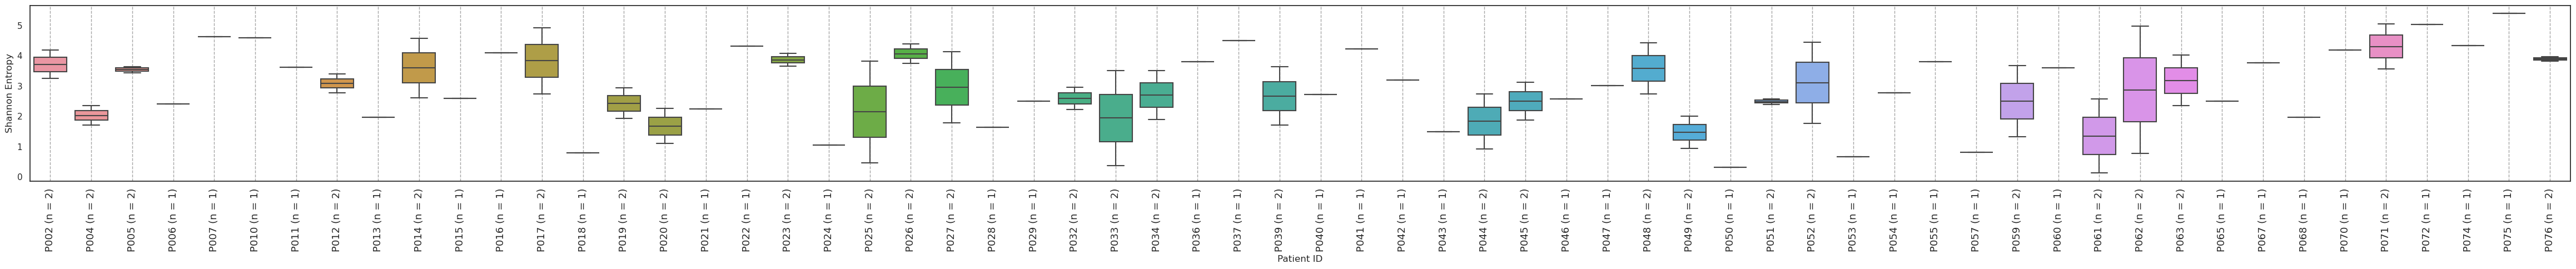

In [169]:
dynamic_boxplot(data=metadata, x_col='Patient_ID', y_col='shannon_entropy', x_col_name='Patient ID', y_col_name='Shannon Entropy')

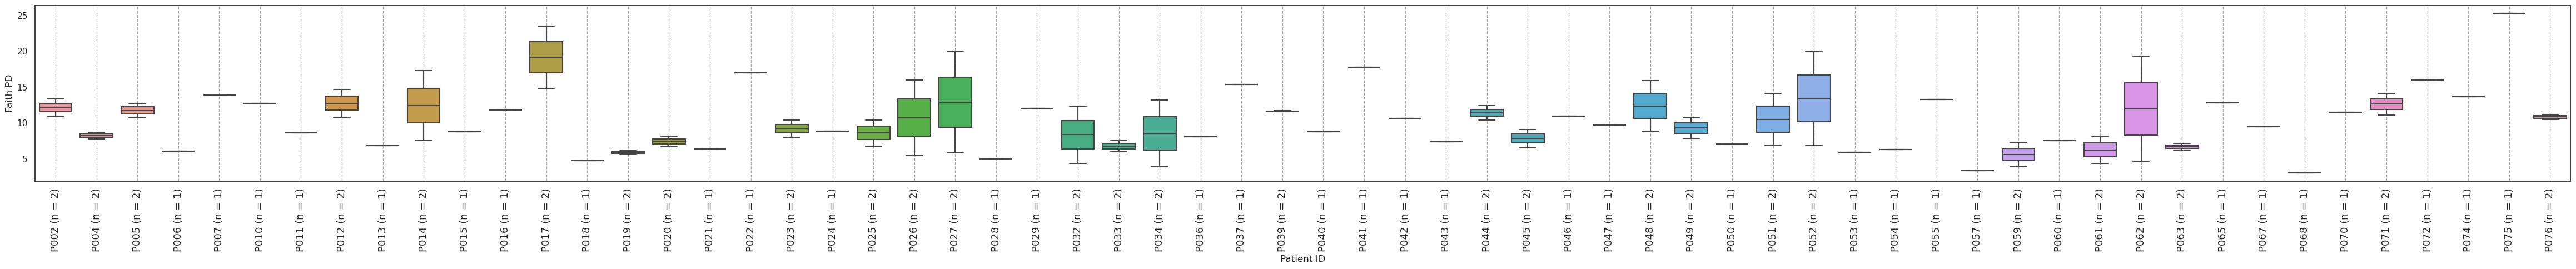

In [170]:
dynamic_boxplot(data=metadata, x_col='Patient_ID', y_col='faith_pd', x_col_name='Patient ID', y_col_name='Faith PD')

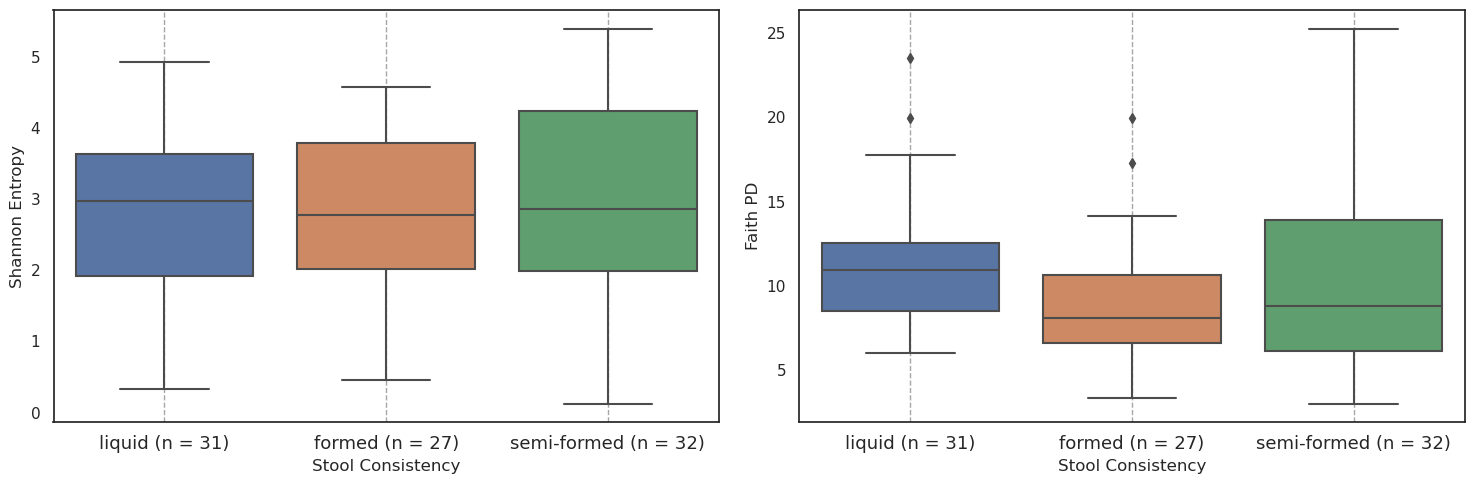

In [171]:
dynamic_boxplot(
    data=metadata, 
    x_col='Stool_Consistency', 
    y_col=['shannon_entropy', 'faith_pd'], 
    x_col_name='Stool Consistency', 
    y_col_name=['Shannon Entropy', 'Faith PD']
)

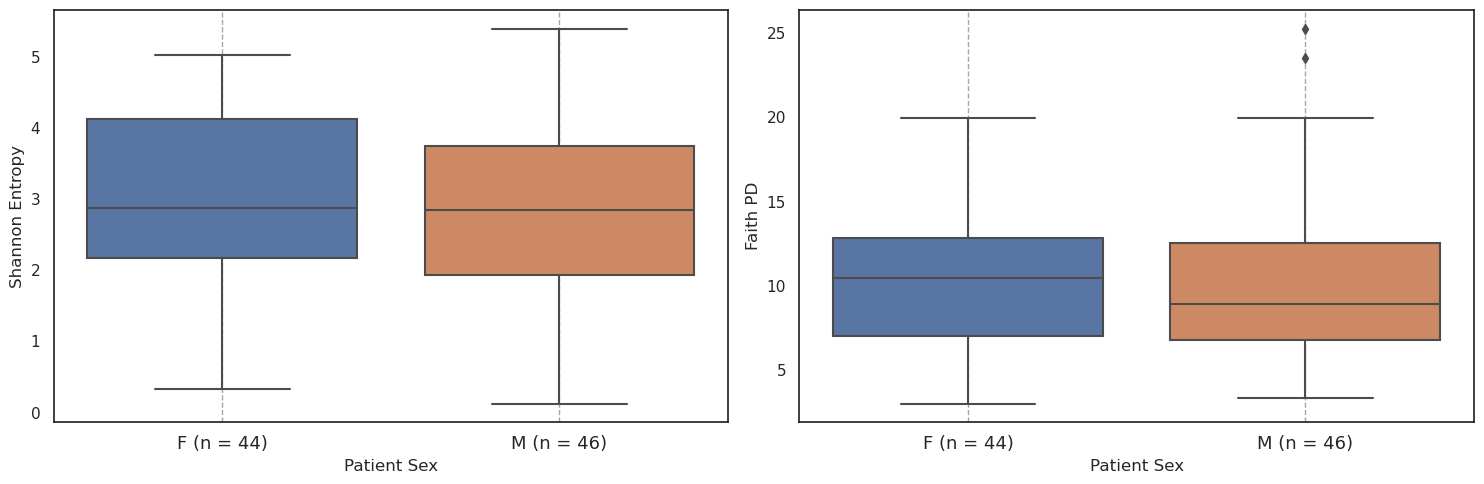

In [172]:
dynamic_boxplot(
    data=metadata, 
    x_col='Patient_Sex', 
    y_col=['shannon_entropy', 'faith_pd'], 
    x_col_name='Patient Sex', 
    y_col_name=['Shannon Entropy', 'Faith PD']
)

In [67]:
#Importing the metadata from the Patient ID statistical results
Shannon_Patient_ID = pd.read_csv(f'{data_dir}/core-metrics-results-bt/shannon-group-significance_exported/kruskal-wallis-pairwise-Patient_ID.csv')
FaithPD_Patient_ID = pd.read_csv(f'{data_dir}/core-metrics-results-bt/faith-pd-group-significance_exported/kruskal-wallis-pairwise-Patient_ID.csv')
print("Number of patients that have a significantly different Shannon Entropy:", len(Shannon_Patient_ID[Shannon_Patient_ID['p-value'] < 0.05]), "and Faith PD:", len(FaithPD_Patient_ID[FaithPD_Patient_ID['p-value'] < 0.05]))

Number of patients that have a significantly different Shannon Entropy: 0 and Faith PD: 0


Defining function to load kruskal-wallis-pairwise test data and check for significant data

In [195]:
def count_and_print_significant_differences(category):
    # Import the CSV files
    Shannon_data = pd.read_csv(f'{data_dir}/core-metrics-results-bt/shannon-group-significance_exported/kruskal-wallis-pairwise-{category}.csv')
    FaithPD_data = pd.read_csv(f'{data_dir}/core-metrics-results-bt/faith-pd-group-significance_exported/kruskal-wallis-pairwise-{category}.csv')
    
    # Filter rows without significant values
    significant_shannon = Shannon_data[Shannon_data['p-value'] < 0.05]
    significant_faithpd = FaithPD_data[FaithPD_data['p-value'] < 0.05]

    print(
        f"Number of patients that have a significantly different Shannon Entropy: {len(significant_shannon)} "
        f"and Faith PD: {len(significant_faithpd)} "
        f"in Category {category}"
    )
    
    results = {}
    if not significant_shannon.empty:
        results['significant_shannon'] = significant_shannon
        # Save Shannon results to Excel if not empty
        significant_shannon.to_excel(f'{vis_dir}/kruskal-wallis-pairwise-{category}-shannon.xlsx', index=False)
    if not significant_faithpd.empty:
        results['significant_faithpd'] = significant_faithpd
        # Save Faith PD results to Excel if not empty
        significant_faithpd.to_excel(f'{vis_dir}/kruskal-wallis-pairwise-{category}-faith.xlsx', index=False)

    return results

In [196]:
count_and_print_significant_differences('Patient_ID')

Number of patients that have a significantly different Shannon Entropy: 0 and Faith PD: 0 in Category Patient_ID


{}

In [197]:
count_and_print_significant_differences('Stool_Consistency')

Number of patients that have a significantly different Shannon Entropy: 0 and Faith PD: 1 in Category Stool_Consistency


{'significant_faithpd':          Group 1        Group 2         H   p-value   q-value
 0  formed (n=30)  liquid (n=31)  5.597503  0.017986  0.053958}

In [198]:
count_and_print_significant_differences('Patient_Sex')

Number of patients that have a significantly different Shannon Entropy: 0 and Faith PD: 0 in Category Patient_Sex


{}

#### Function to calculate Spearman correlation, p-value, and sample size


In [15]:
def calculate_spearman(x, y):
    correlation, p_value = spearmanr(x, y)
    sample_size = len(x)  # Calculate sample size
    return correlation, p_value, sample_size

# List of columns to compare
columns_to_check = ['Sample_Day', 'Recovery_Day', 'Cohort_Number']
columns_to_compare = ['shannon_entropy', 'faith_pd']

# Store results in a list
results = []

# Loop through all combinations of columns
for col1 in columns_to_check:
    for col2 in columns_to_compare:
        # For 'Recovery_Day', drop NaN only for this column
        if col1 == 'Recovery_Day':
            metadata_clean = metadata.dropna(subset=[col1])
        else:
            metadata_clean = metadata
        
        # Calculate Spearman correlation after cleaning
        correlation, p_value, sample_size = calculate_spearman(metadata_clean[col1], metadata_clean[col2])
        
        # Store results
        results.append({
            'Column1': col1,
            'Column2': col2,
            'Correlation': correlation,
            'P-value': p_value,
            'Sample Size': sample_size
        })

# Convert results to a DataFrame for better display
Spearman_results = pd.DataFrame(results)

# Display the results
print(Spearman_results)

#Save results as excel file
Spearman_results.to_excel(f'{vis_dir}/Spearman_results.xlsx', index=False)

         Column1          Column2  Correlation       P-value  Sample Size
0     Sample_Day  shannon_entropy    -0.524423  5.790941e-08           94
1     Sample_Day         faith_pd    -0.493409  4.352811e-07           94
2   Recovery_Day  shannon_entropy     0.006885  9.483532e-01           91
3   Recovery_Day         faith_pd    -0.036206  7.333139e-01           91
4  Cohort_Number  shannon_entropy    -0.567812  2.398329e-09           94
5  Cohort_Number         faith_pd    -0.536332  2.526283e-08           94


#### Function to visualize numerical correlations as scatterplots

In [181]:
def dynamic_scatterplot_grid(data, x_cols, y_cols, x_col_names, y_col_names, figure_width=10, height=5):
    """
    Creates scatterplots for multiple y columns, arranged beneath each other, with multiple x columns.
    The figure is also saved to the specified directory.
    
    Parameters:
        data (pd.DataFrame): The dataset to use for plotting.
        x_cols (list): A list containing the names of the columns to use for the x-axis.
        y_cols (list): A list containing the names of the columns to use for the y-axis.
        x_col_names (list): List of labels for the x-axis (must match the length of x_cols).
        y_col_names (list): List of labels for the y-axis (must match the length of y_cols).
        vis_dir (str): The directory where the plot will be saved.
        figure_width (float, optional): Width of the figure. Defaults to 10.
        height (float, optional): Height of the figure. Defaults to 5.
    """
    
    # Ensure columns are numeric and drop any rows with NaN values in x_cols or y_cols
    data[x_cols] = data[x_cols].apply(pd.to_numeric, errors='coerce')
    data[y_cols] = data[y_cols].apply(pd.to_numeric, errors='coerce')
    data.dropna(subset=x_cols + y_cols, inplace=True)
    
    # Set the dynamic figure size
    sns.set(rc={'figure.figsize': (figure_width, height)}, style='white')
    
    # Calculate grid dimensions: len(y_cols) rows and len(x_cols) columns
    n_rows = len(y_cols)
    n_cols = len(x_cols)  # Number of x-axis columns
    
    # Create the figure and axes for subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figure_width * n_cols, height * n_rows))
    
    # Ensure y_col_names has the same length as y_cols
    if len(y_col_names) != len(y_cols):
        raise ValueError("y_col_names must have the same length as y_cols.")
    
    if len(x_col_names) != len(x_cols):
        raise ValueError("x_col_names must have the same length as x_cols.")
    
    # Flatten axes for easier indexing if needed
    if n_rows == 1:
        axes = axes.reshape(1, n_cols)
    axes = axes.flatten()
    
    # Loop through each combination of x and y columns to create scatterplots
    for i, (y_col, y_name) in enumerate(zip(y_cols, y_col_names)):
        for j, (x_col, x_name) in enumerate(zip(x_cols, x_col_names)):
            ax = axes[i * n_cols + j]
            
            # Create the scatter plot for each x and y pair
            sns.scatterplot(data=data, x=x_col, y=y_col, ax=ax)
            
            # Set axis labels
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
    
    # Automatically adjust layout
    plt.tight_layout()
    
    # Construct the filename from x_cols and y_cols names
    x_cols_str = '_'.join(x_cols)
    y_cols_str = '_'.join(y_cols)
    filename = f"alpha_diversity_{x_cols_str}_{y_cols_str}.png"
    
    # Ensure the vis_dir exists
    os.makedirs(vis_dir, exist_ok=True)

    # Save the plot to the specified directory
    save_path = os.path.join(vis_dir, filename)
    plt.savefig(save_path, format='png')
    
    # Display the plot
    plt.show()

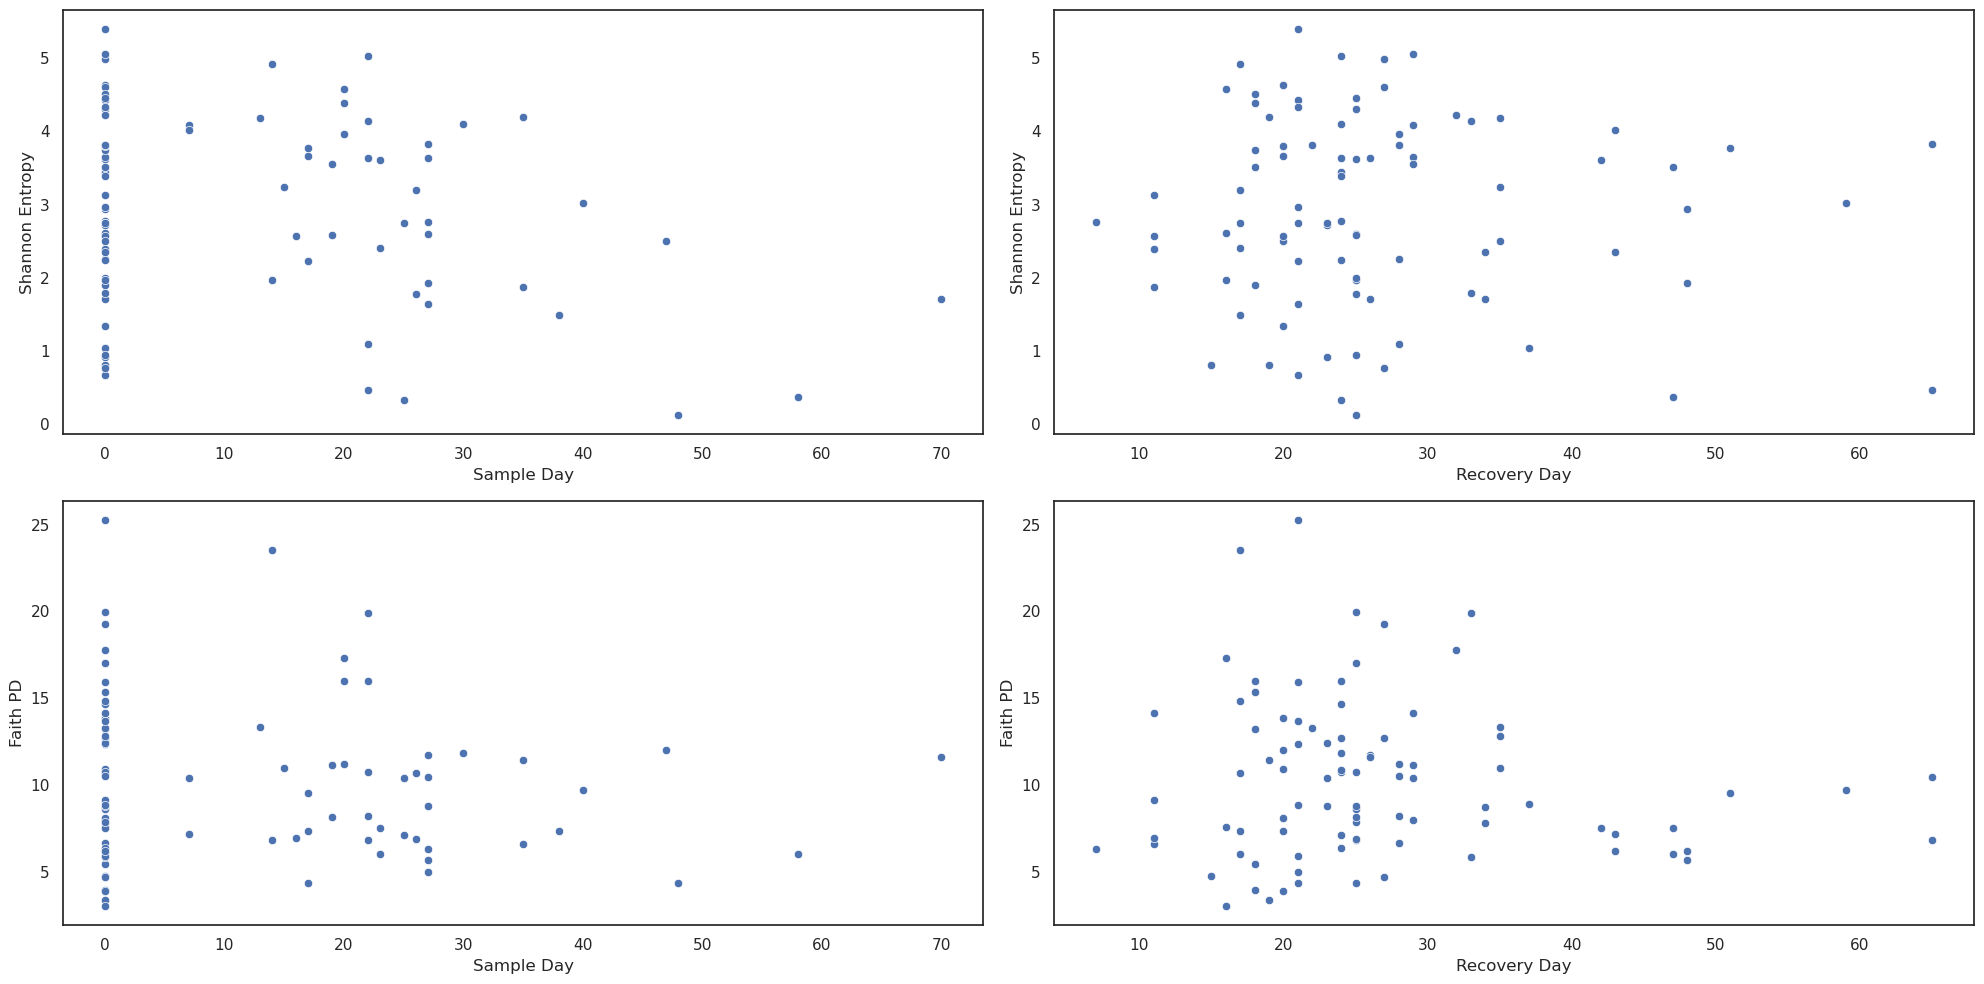

In [182]:
dynamic_scatterplot_grid(
    metadata, 
    x_cols=['Sample_Day', 'Recovery_Day'], 
    y_cols=['shannon_entropy', 'faith_pd'], 
    x_col_names=['Sample Day', 'Recovery Day'], 
    y_col_names=['Shannon Entropy', 'Faith PD']
)

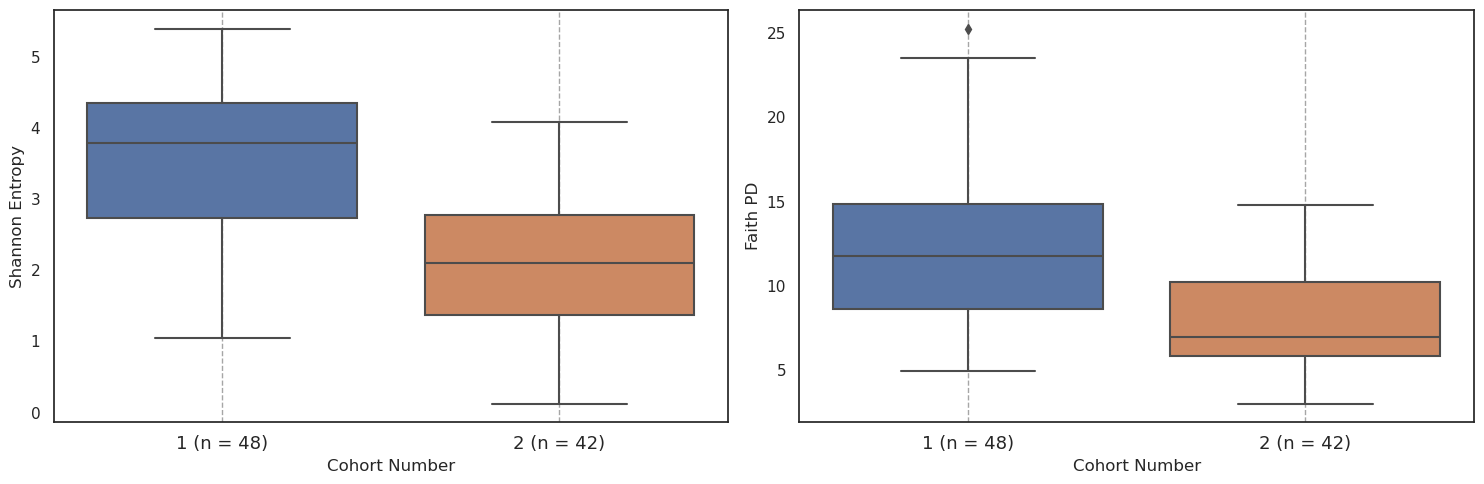

In [173]:
dynamic_boxplot(
    data=metadata, 
    x_col='Cohort_Number', 
    y_col=['shannon_entropy', 'faith_pd'], 
    x_col_name='Cohort Number', 
    y_col_name=['Shannon Entropy', 'Faith PD']
)